# Classification of Malicious URL using Deep Learning with Keras
**University of Toronto School of Continuing Studies** \
SCS 3546 Deep Learning


Name: <pre>Arjie Cristobal</pre>
Student Number: <pre>X261973</pre>

**Install Scikeras libraries**

In [119]:
!pip install scikeras

**Import Required Python libraries**

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from keras.metrics import Accuracy, F1Score
from keras.models import Sequential
from keras.utils import to_categorical
from keras import backend as K
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier, KerasRegressor


warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

np.random.seed(42)
tf.random.set_seed(42)

In [121]:
# mount the colab
from google.colab import drive
drive.mount('/content/drive')

# For saving and retrieving the trained model
WORKSPACE_PATH = "/content/drive/MyDrive/Colab Notebooks/models/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the dataset



In [122]:
# Read the dataset from github
url = 'https://raw.githubusercontent.com/quickheaven/scs-3546-deep-learning/master/datasets/'

X_train = pd.read_csv(url + 'X_train.csv', index_col=0)
X_test =pd.read_csv(url + 'X_test.csv', index_col=0)

y_train =pd.read_csv(url + 'y_train.csv', index_col=0)
y_test = pd.read_csv(url + 'y_test.csv', index_col=0)

In [123]:
# Initialize input dim and output nodes
NUM_INPUT_DIM = X_train.shape[1]
NUM_OUTPUT_NODES = len(y_train['URL_Type_obf_Type'].unique())

#
y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)

# Training and Tuning Model

The training and tuning of model is divided into three main experiments. Tuning of Deep Network, Tuning the Back Propagation and last is the Overfitting Management.

The first step before proceeding to other experiments is Tuning the Neural Network. These includes determining first the epoch and batch size to use, the number of hidden layers to add, the number of nodes in each layer, choosing the activation function and the weight initializer.

The second part is Tuning the Back Propagation. It involves whether to use Batch normalization or not, finding the right Optimizers and its Learning Rates.

Lastly is the Overfitting Management, I used Regularation and Dropout as part of the experiment.

In [124]:
def get_base_model_config():
  """
  This function returns the based model configuration for the experiments.

  Parameters
  ----------
  None

  Returns
  ----------
  dict - The dictionary containing the based model configuration.
  """

  early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
  callbacks = [early_stopping_callback]

  model_config = {
      # ##################################
      "model_name": None,
      "input_dim": NUM_INPUT_DIM,
      "custom_layers": list(),
      "callbacks": callbacks,
      "validation_split": 0.20,
      "loss": "categorical_crossentropy",
      "output_nodes": NUM_OUTPUT_NODES,
      "output_activation": "softmax",
      "metrics": ['accuracy'],
      # ##################################
      "batch_size": 32,
      "epochs": 200,
      "hidden_activation": "relu",
      "weights_initializer": "random_normal",
      # ##################################
      "normalization": None,
      "optimizer": "adam",
      "learning_rate": 0.001,
      "regularizer": None,
      "dropout_rate": None,
      # ##################################
      "is_save_model": False,
      "workspace_path": WORKSPACE_PATH,
      "verbose": 1
  }
  return model_config


In [125]:
def get_optimizer(optimizer_name, learning_rate):
  """
  (str. float) -> keras.optimizers

  This method returns the optimizer that will be use in the experiment.

  Parameters
  ----------
  optimizer_name - The name of the optimizer to use in the experiment. values are adagrad, rmsprop, adam and None.
  learning_rate - The rate of learning to use in the optimizer.

  Returns
  ----------
  keras.optimizer - The keras optimizer object.
  """
  optimizer=None
  if optimizer_name == 'adagrad':
      optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif 'rmsprop':
      optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif'adam' :
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  else :
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

  return optimizer

In [126]:
def create_and_run_model(model_config, X, y):

  # Build the new model
  model = Sequential(layers=model_config['custom_layers'], name=model_config['model_name'])
  model.summary()

  optimizer = get_optimizer(model_config["optimizer"], model_config["learning_rate"])

  # Compile the model
  model.compile(optimizer=optimizer,
                loss=model_config['loss'],
                metrics=model_config['metrics'])

  # Fit the model
  history = model.fit(X, y,
                      batch_size=model_config['batch_size'],
                      callbacks=model_config['callbacks'],
                      epochs=model_config['epochs'],
                      validation_split=model_config['validation_split'],
                      verbose=model_config["verbose"])

  if True == model_config['is_save_model']:
    model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
    model.save(model_file)

  return history

In [127]:
def plot_accuracy_measures(accuracy_measures, title):

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment],
                 label=experiment,
                    linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [128]:
def plot_learning_curves(history, title):
  # plot curves for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Learning Curves ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.plot(figsize=(8, 5))
  plt.grid(True)
  plt.show()

In [129]:
model_config = get_base_model_config()

## Tuning Deep Neural Network

### Epoch and Batch size tuning
Figure out the right number of batches and epochs first, and then use that for further experimentation.

**Batch Size:** Experiment for the right size, batch size of 32 found most optimal for most use cases.

**Epoch:** Choose the earliest value when accuracy stabilizers.


Model: "Epoch_and_batch_size_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 16)                832       
                                                                 
 dense_51 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 8s 10ms/step - loss: 1.3167 - accuracy: 0.5383 - val_loss: 1.0959 - val_accuracy: 0.6248
Epoch 2/200
636/636 [==============================] - 4s 7ms/step - loss: 0.9955 - accuracy: 0.6536 - val_loss: 0.9191 - val_accuracy: 0.6771
Epoch 3/200
636/636 [==============================] - 4s 7ms/step - loss: 0.8850 - accuracy: 0.6844 - val_loss: 0.8489 - 

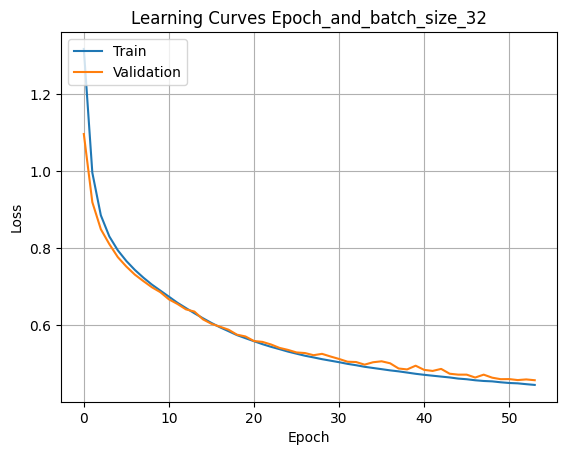

Model: "Epoch_and_batch_size_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 16)                832       
                                                                 
 dense_53 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
318/318 [==============================] - 2s 5ms/step - loss: 1.4123 - accuracy: 0.4868 - val_loss: 1.2115 - val_accuracy: 0.6165
Epoch 2/200
318/318 [==============================] - 1s 4ms/step - loss: 1.0936 - accuracy: 0.6347 - val_loss: 0.9959 - val_accuracy: 0.6755
Epoch 3/200
318/318 [==============================] - 1s 4ms/step - loss: 0.9549 - accuracy: 0.6751 - val_loss: 0.9019 - v

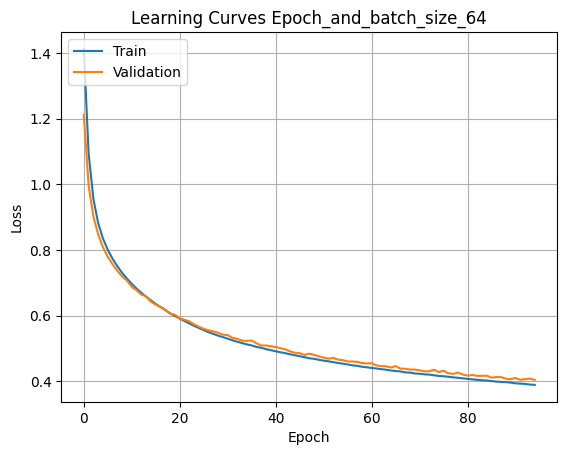

Model: "Epoch_and_batch_size_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 16)                832       
                                                                 
 dense_55 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
159/159 [==============================] - 1s 5ms/step - loss: 1.5260 - accuracy: 0.4117 - val_loss: 1.4208 - val_accuracy: 0.5252
Epoch 2/200
159/159 [==============================] - 1s 4ms/step - loss: 1.3198 - accuracy: 0.5661 - val_loss: 1.2154 - val_accuracy: 0.6120
Epoch 3/200
159/159 [==============================] - 1s 4ms/step - loss: 1.1494 - accuracy: 0.6192 - val_loss: 1.0807 - 

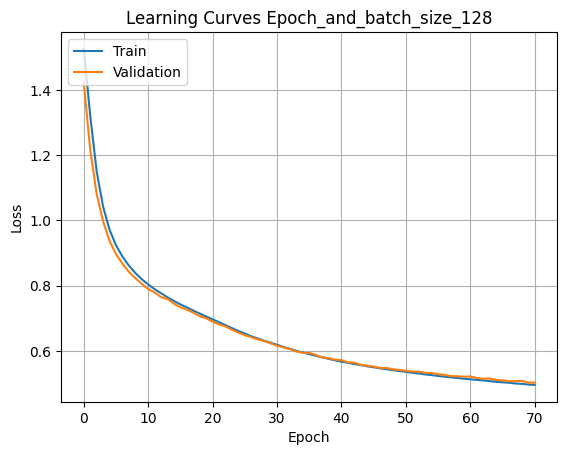

In [130]:
accuracy_measures = {}
model_config = get_base_model_config()

batch_sizes = [32, 64, 128]

for size in batch_sizes:

  model_config['batch_size'] = size

  custom_layers = [
      layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];
  model_name = 'Epoch_and_batch_size_' + str(size)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [131]:
accuracy_measures_batch_epoch = accuracy_measures.copy()

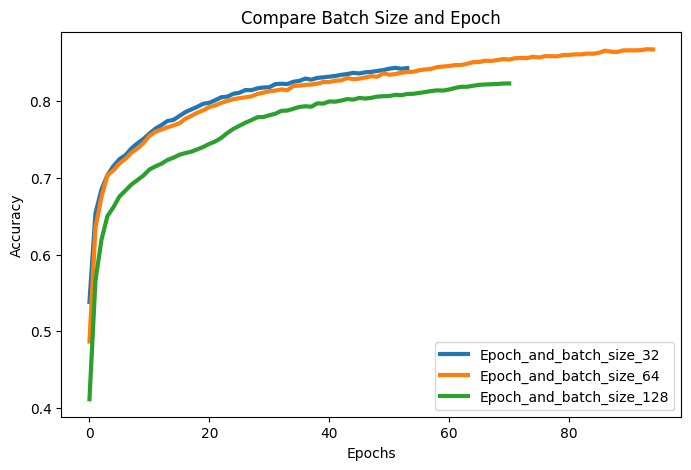

In [132]:
plot_accuracy_measures(accuracy_measures, "Compare Batch Size and Epoch")

The model with batch_size_64 offers higher accuracy.

In [134]:
model_config['batch_size'] = 64
model_config['epochs'] = 90

### Hidden layers tuning

One of the key model architecture hyperparameters is the number of hidden layers. As the number of layers increases, it increases the possibility of learning complex relationships between features and target variables, but it will also increase the cost and time needed for both training and inference. It is also has the risk of overfitting the training set.

A **value of two** has been sufficient for simple problems. It is recommended to increase the number of layers only based on experimentation if the set accuracy levels are not achieved. Otherwise, additional layers will take resources and time without providing any additional value.

Model: "Layers_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 16)                832       
                                                                 
 dense_57 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 2s 5ms/step - loss: 1.4142 - accuracy: 0.4727 - val_loss: 1.2261 - val_accuracy: 0.6051
Epoch 2/90
318/318 [==============================] - 1s 4ms/step - loss: 1.1174 - accuracy: 0.6267 - val_loss: 1.0175 - val_accuracy: 0.6486
Epoch 3/90
318/318 [==============================] - 1s 4ms/step - loss: 0.9707 - accuracy: 0.6564 - val_loss: 0.9144 - val_accuracy: 0.670

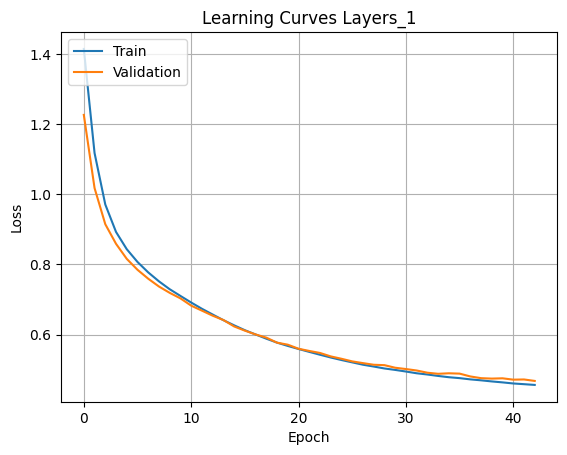

Model: "Layers_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 16)                832       
                                                                 
 dense_59 (Dense)            (None, 16)                272       
                                                                 
 dense_60 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 2s 5ms/step - loss: 1.3267 - accuracy: 0.5185 - val_loss: 1.0831 - val_accuracy: 0.6279
Epoch 2/90
318/318 [==============================] - 2s 7ms/step - loss: 0.9799 - accuracy: 0.6646 - val_loss: 0.9064 - val_accuracy: 0.6777
Epoch 

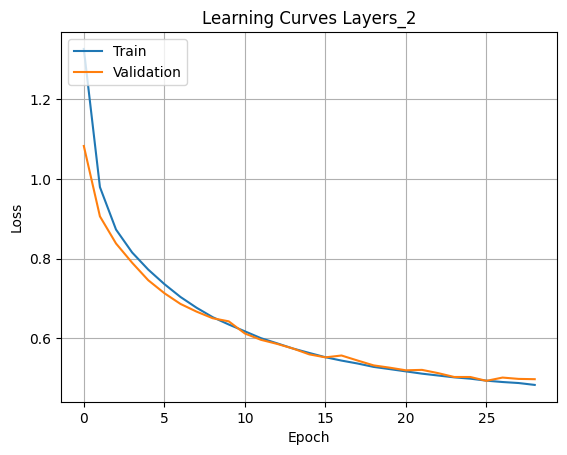

Model: "Layers_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 16)                832       
                                                                 
 dense_62 (Dense)            (None, 16)                272       
                                                                 
 dense_63 (Dense)            (None, 16)                272       
                                                                 
 dense_64 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1461 (5.71 KB)
Trainable params: 1461 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 6ms/step - loss: 1.3629 - accuracy: 0.4878 - val_loss: 1.1374 - val_accuracy: 0.5822
Epoch 2/90
318/3

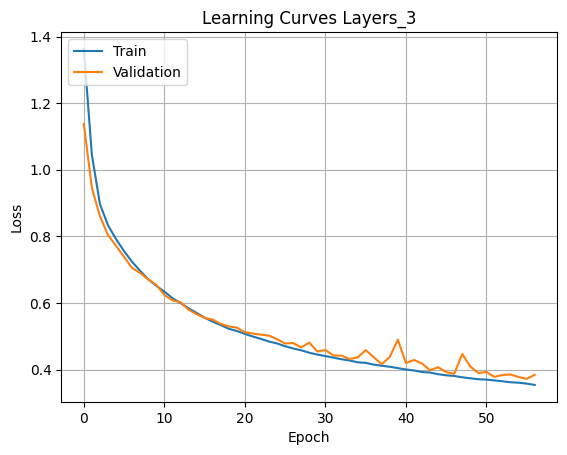

Model: "Layers_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 16)                832       
                                                                 
 dense_66 (Dense)            (None, 16)                272       
                                                                 
 dense_67 (Dense)            (None, 16)                272       
                                                                 
 dense_68 (Dense)            (None, 16)                272       
                                                                 
 dense_69 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1733 (6.77 KB)
Trainable params: 1733 (6.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [======

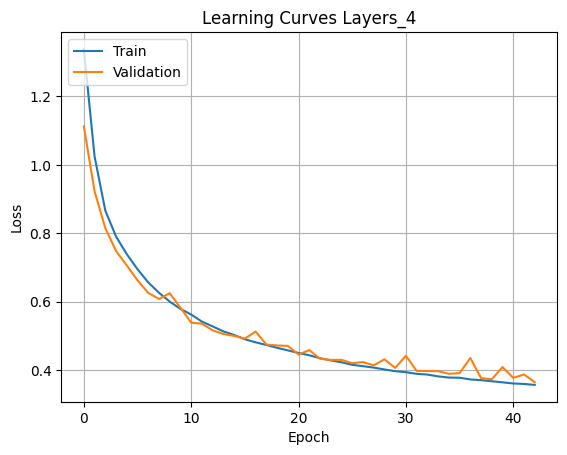

Model: "Layers_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 16)                832       
                                                                 
 dense_71 (Dense)            (None, 16)                272       
                                                                 
 dense_72 (Dense)            (None, 16)                272       
                                                                 
 dense_73 (Dense)            (None, 16)                272       
                                                                 
 dense_74 (Dense)            (None, 16)                272       
                                                                 
 dense_75 (Dense)            (None, 5)                 85        
                                                                 
Total params: 2005 (7.83 KB)
Trainable params: 2005 (7.83 

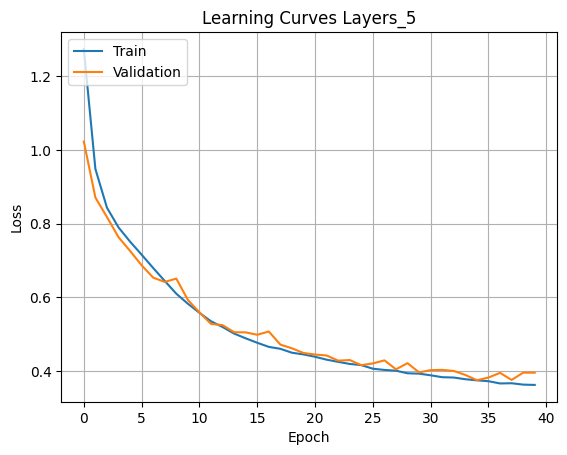

Model: "Layers_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 16)                832       
                                                                 
 dense_77 (Dense)            (None, 16)                272       
                                                                 
 dense_78 (Dense)            (None, 16)                272       
                                                                 
 dense_79 (Dense)            (None, 16)                272       
                                                                 
 dense_80 (Dense)            (None, 16)                272       
                                                                 
 dense_81 (Dense)            (None, 16)                272       
                                                                 
 dense_82 (Dense)            (None, 5)                 85 

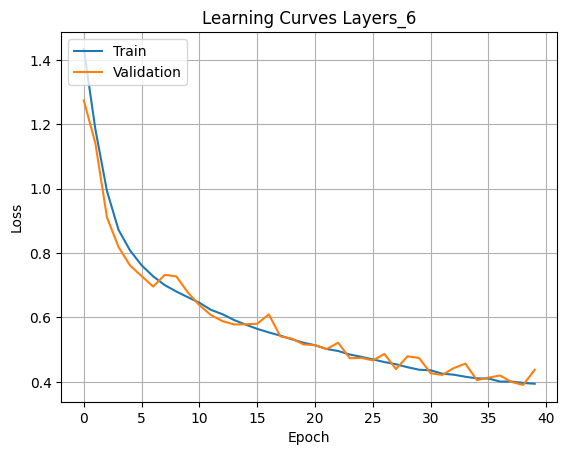

Model: "Layers_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 16)                832       
                                                                 
 dense_84 (Dense)            (None, 16)                272       
                                                                 
 dense_85 (Dense)            (None, 16)                272       
                                                                 
 dense_86 (Dense)            (None, 16)                272       
                                                                 
 dense_87 (Dense)            (None, 16)                272       
                                                                 
 dense_88 (Dense)            (None, 16)                272       
                                                                 
 dense_89 (Dense)            (None, 16)                272

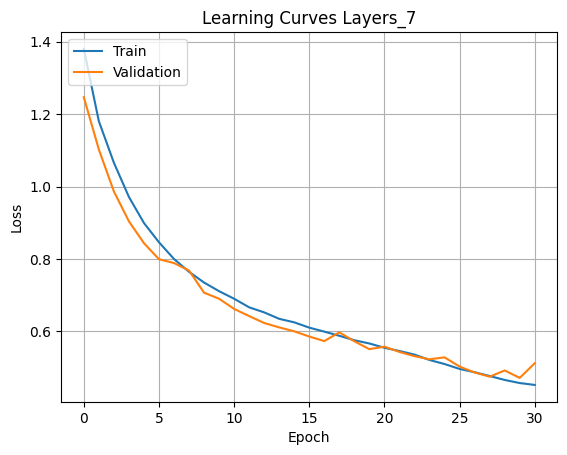

Model: "Layers_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 16)                832       
                                                                 
 dense_92 (Dense)            (None, 16)                272       
                                                                 
 dense_93 (Dense)            (None, 16)                272       
                                                                 
 dense_94 (Dense)            (None, 16)                272       
                                                                 
 dense_95 (Dense)            (None, 16)                272       
                                                                 
 dense_96 (Dense)            (None, 16)                272       
                                                                 
 dense_97 (Dense)            (None, 16)                272

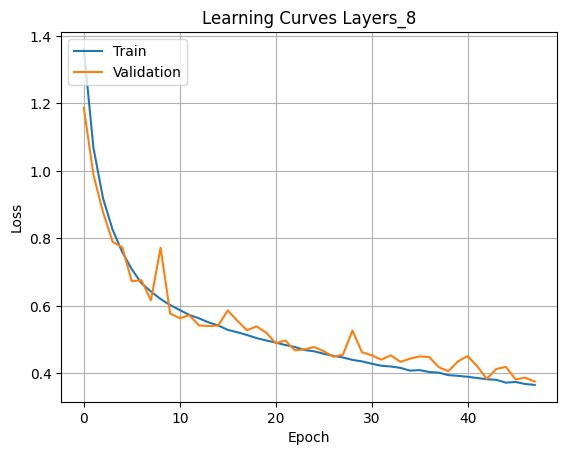

Model: "Layers_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 16)                832       
                                                                 
 dense_101 (Dense)           (None, 16)                272       
                                                                 
 dense_102 (Dense)           (None, 16)                272       
                                                                 
 dense_103 (Dense)           (None, 16)                272       
                                                                 
 dense_104 (Dense)           (None, 16)                272       
                                                                 
 dense_105 (Dense)           (None, 16)                272       
                                                                 
 dense_106 (Dense)           (None, 16)                272

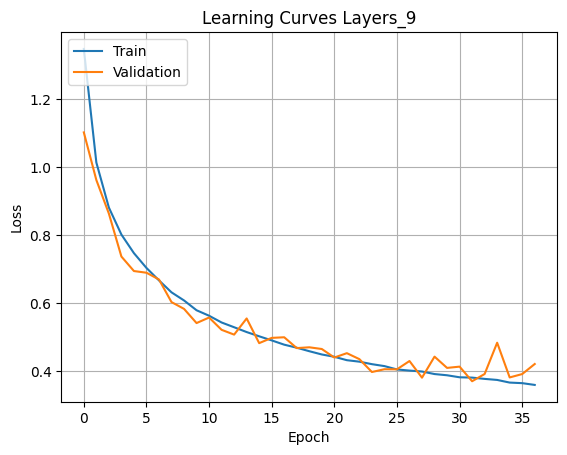

Model: "Layers_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 16)                832       
                                                                 
 dense_111 (Dense)           (None, 16)                272       
                                                                 
 dense_112 (Dense)           (None, 16)                272       
                                                                 
 dense_113 (Dense)           (None, 16)                272       
                                                                 
 dense_114 (Dense)           (None, 16)                272       
                                                                 
 dense_115 (Dense)           (None, 16)                272       
                                                                 
 dense_116 (Dense)           (None, 16)                27

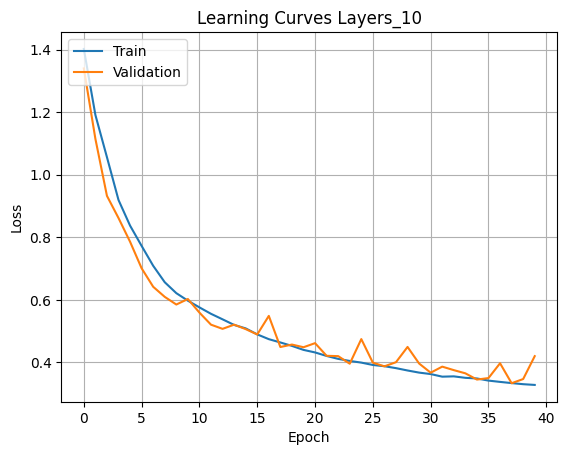

In [135]:
model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90

accuracy_measures = {}

# reused the previous model config from previous experiment.
# but on this case only increase the number of layers

# I will start small by checking if one or two nodes is enough to get a good result.
layer_list = []
for hidden_layer_count in range(1,11):
  custom_layers = []

  # Simply use 16 nodes per layer for now.

  # Input
  if hidden_layer_count == 1:
    custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
  else:
  # Additional Layers
    custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
    for i in range(1, hidden_layer_count):
      custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation']))

  # Output layers
  custom_layers.append(layers.Dense(model_config['output_nodes'], activation=model_config['output_activation']))

  model_name = 'Layers_' + str(hidden_layer_count)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [136]:
accuracy_measures_hidden_layers = accuracy_measures.copy()

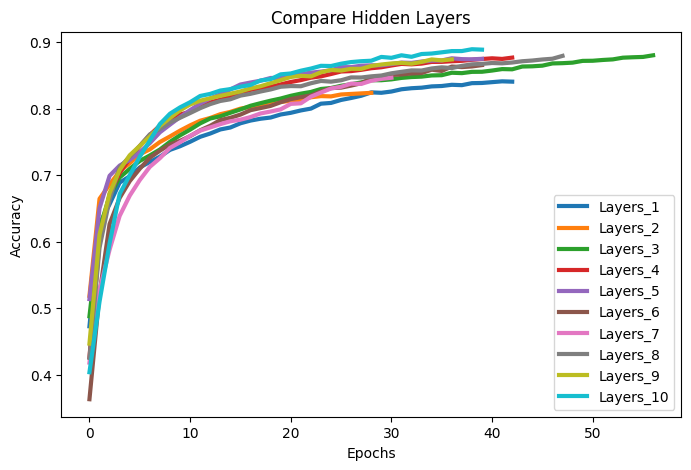

In [137]:
plot_accuracy_measures(accuracy_measures, "Compare Hidden Layers")

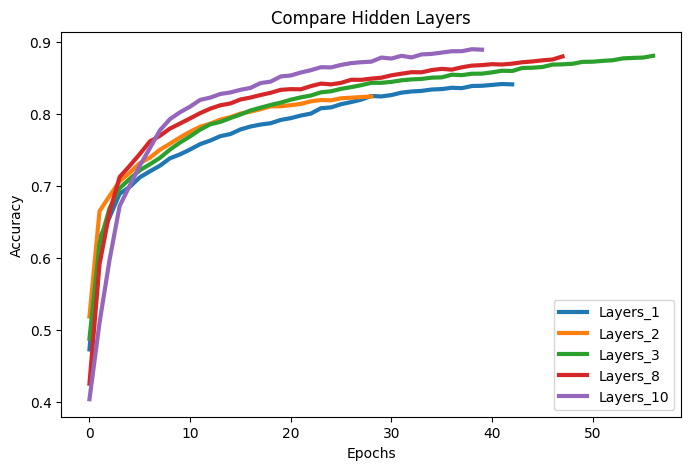

In [141]:
accuracy_measures_tmp = {}
accuracy_measures_tmp['Layers_1'] = accuracy_measures['Layers_1']
accuracy_measures_tmp['Layers_2'] = accuracy_measures['Layers_2']
accuracy_measures_tmp['Layers_3'] = accuracy_measures['Layers_3']
accuracy_measures_tmp['Layers_8'] = accuracy_measures['Layers_8']
accuracy_measures_tmp['Layers_10'] = accuracy_measures['Layers_10']

plot_accuracy_measures(accuracy_measures_tmp, "Compare Hidden Layers")

The Layers_8 and Layers_10 completed faster but looking to individual learning curve, they are not stable unlike the model with the first three layers. On those first three models, the model Layers_3 offers a balance between a higher accuracy and stability. The succeeding models with higher number of layers offers a better accuracy but those are starting to show signs of overfitting.

Hence, I will choose the model Layers_3. It is also a good idea to start with smaller number of layers.

### Determining nodes in a layers
More nodes means more possibility for the model to learn complex relationships. However similar to number of layers, it will results to more training and resources.

On my experiment I started with a low number of 16 nodes.


Model: "Nodes-16-16-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 16)                832       
                                                                 
 dense_128 (Dense)           (None, 16)                272       
                                                                 
 dense_129 (Dense)           (None, 16)                272       
                                                                 
 dense_130 (Dense)           (None, 5)                 85        
                                                                 
Total params: 1461 (5.71 KB)
Trainable params: 1461 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.2040 - accuracy: 0.5479 - val_loss: 0.9381 - val_accuracy: 0.6621
Epoch 2/40

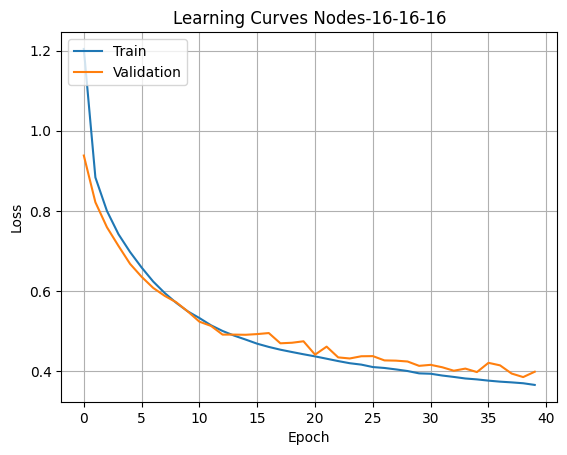

Model: "Nodes-16-24-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 16)                832       
                                                                 
 dense_132 (Dense)           (None, 24)                408       
                                                                 
 dense_133 (Dense)           (None, 16)                400       
                                                                 
 dense_134 (Dense)           (None, 5)                 85        
                                                                 
Total params: 1725 (6.74 KB)
Trainable params: 1725 (6.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.2385 - accuracy: 0.5185 - val_loss: 0.9771 - val_accuracy: 0.6185
Epoch 2/40

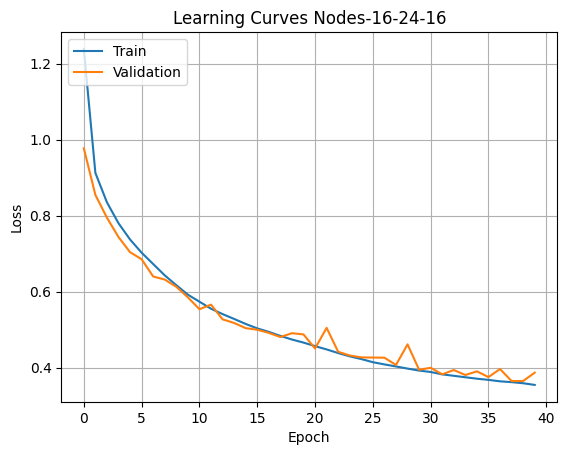

Model: "Nodes-24-16-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 24)                1248      
                                                                 
 dense_136 (Dense)           (None, 16)                400       
                                                                 
 dense_137 (Dense)           (None, 16)                272       
                                                                 
 dense_138 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2005 (7.83 KB)
Trainable params: 2005 (7.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.1876 - accuracy: 0.5606 - val_loss: 0.9451 - val_accuracy: 0.6545
Epoch 2/40

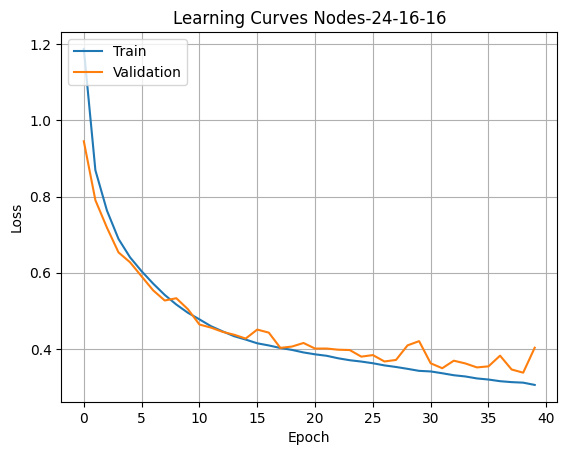

Model: "Nodes-24-24-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 24)                1248      
                                                                 
 dense_140 (Dense)           (None, 24)                600       
                                                                 
 dense_141 (Dense)           (None, 16)                400       
                                                                 
 dense_142 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2333 (9.11 KB)
Trainable params: 2333 (9.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 4s 4ms/step - loss: 1.1893 - accuracy: 0.5647 - val_loss: 0.9274 - val_accuracy: 0.6859
Epoch 2/40

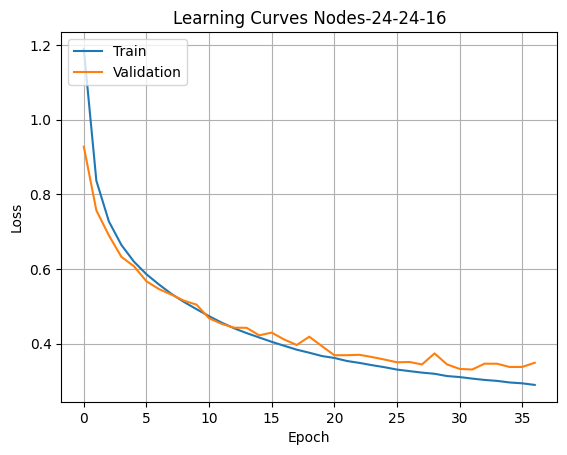

Model: "Nodes-32-16-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 32)                1664      
                                                                 
 dense_144 (Dense)           (None, 16)                528       
                                                                 
 dense_145 (Dense)           (None, 16)                272       
                                                                 
 dense_146 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.1802 - accuracy: 0.5775 - val_loss: 0.9196 - val_accuracy: 0.7003
Epoch 2/40

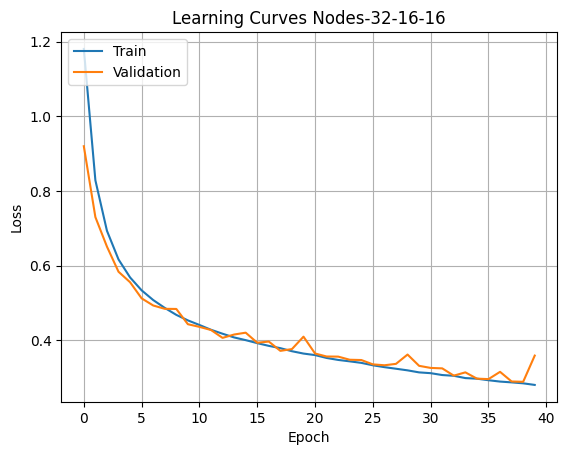

Model: "Nodes-32-24-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 32)                1664      
                                                                 
 dense_148 (Dense)           (None, 24)                792       
                                                                 
 dense_149 (Dense)           (None, 16)                400       
                                                                 
 dense_150 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2941 (11.49 KB)
Trainable params: 2941 (11.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
636/636 [==============================] - 3s 4ms/step - loss: 1.1177 - accuracy: 0.6037 - val_loss: 0.8663 - val_accuracy: 0.6814
Epoch 2/

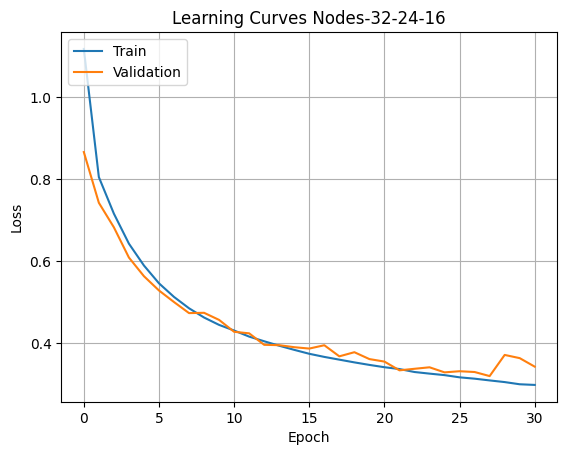

In [ ]:
# reset the accuracy measures
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90

# Exhaustive approach. Try all combinations of layers and the number of nodes;
node_list_layer_1 = [16, 24, 32]
node_list_layer_2 = [16, 24]
node_list_layer_3 = [16]

for nbr_of_nodes_layer_1 in node_list_layer_1:
  for nbr_of_nodes_layer_2 in node_list_layer_2:
    for nbr_of_nodes_layer_3 in node_list_layer_3:
        custom_layers = [
          layers.Dense(nbr_of_nodes_layer_1, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
          layers.Dense(nbr_of_nodes_layer_2, activation=model_config['hidden_activation']),
          layers.Dense(nbr_of_nodes_layer_3, activation=model_config['hidden_activation']),
          layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
        ];
        model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2) + '-' + str(nbr_of_nodes_layer_3)
        model_config['model_name'] = model_name
        model_config['custom_layers'].clear()
        model_config['custom_layers'].extend(custom_layers)

        history = create_and_run_model(model_config, X_train, y_train_dummy)
        plot_learning_curves(history, model_name)
        accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_nodes = accuracy_measures.copy()

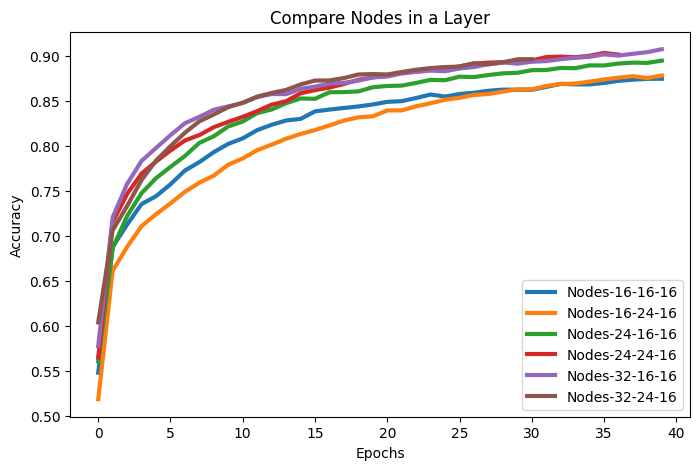

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Nodes in a Layer")

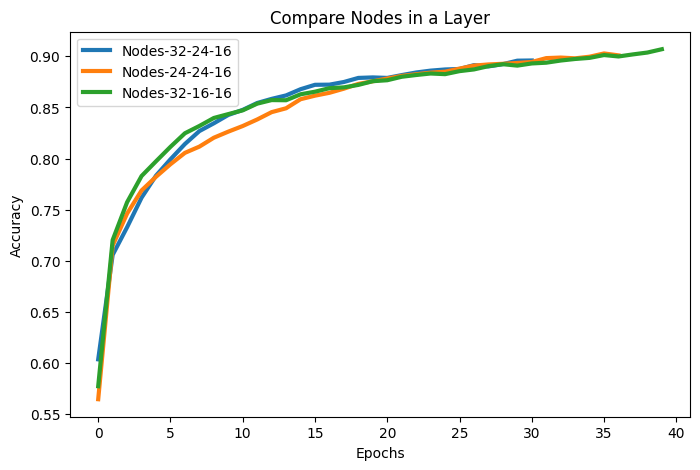

In [ ]:
accuracy_measures_tmp = {}
accuracy_measures_tmp['Nodes-32-24-16'] = accuracy_measures['Nodes-32-24-16']
accuracy_measures_tmp['Nodes-32-16-16'] = accuracy_measures['Nodes-32-16-16']
accuracy_measures_tmp['Nodes-24-24-16'] = accuracy_measures['Nodes-24-24-16']

plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

The models above almost have similar accuracy but model Nodes-32-16-16 have slightly higher accuracy and less signs of overfitting.

### Choosing Activation Function

There are number of algorithms available for activation functions. In general, rectified linear unit works best for regular  artificial neural network (ANN) and convolutional network (CNN). Sigmoid works best for RNNs.


Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 32)                1664      
                                                                 
 dense_122 (Dense)           (None, 16)                528       
                                                                 
 dense_123 (Dense)           (None, 16)                272       
                                                                 
 dense_124 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 7ms/step - loss: 1.2109 - accuracy: 0.5566 - val_loss: 0.9565 - val_accuracy: 0.6547
Epoch 2/90
318

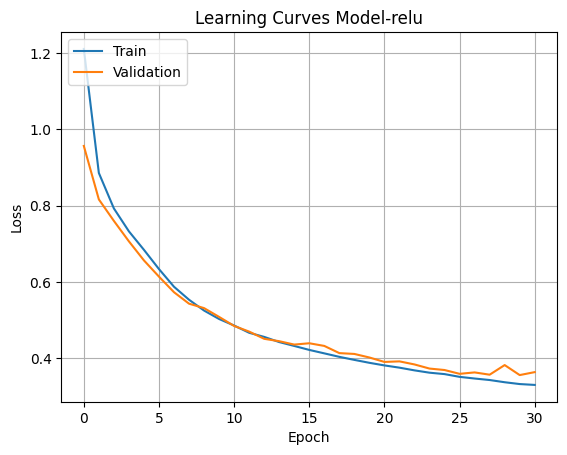

Model: "Model-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 32)                1664      
                                                                 
 dense_126 (Dense)           (None, 16)                528       
                                                                 
 dense_127 (Dense)           (None, 16)                272       
                                                                 
 dense_128 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 5ms/step - loss: 1.6292 - accuracy: 0.2212 - val_loss: 1.5993 - val_accuracy: 0.3589
Epoch 2/90


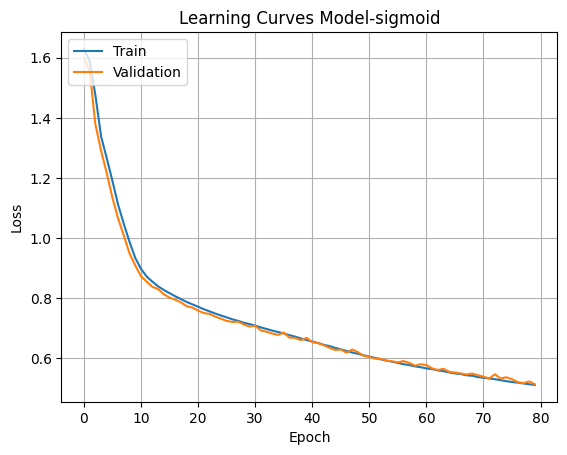

Model: "Model-tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 32)                1664      
                                                                 
 dense_130 (Dense)           (None, 16)                528       
                                                                 
 dense_131 (Dense)           (None, 16)                272       
                                                                 
 dense_132 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 2s 5ms/step - loss: 1.1527 - accuracy: 0.5866 - val_loss: 0.8905 - val_accuracy: 0.6745
Epoch 2/90
318

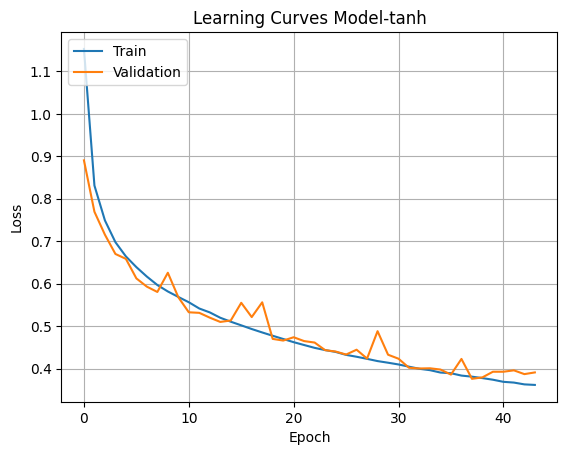

In [142]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90
# Number of layers: 3
# Number of nodes per each layer: 32-16-16

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:

  model_config['hidden_activation'] = activation

  custom_layers = [
    layers.Dense(32, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, activation=model_config['hidden_activation']),
    layers.Dense(16, activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + activation
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [143]:
accuracy_activation = accuracy_measures.copy()

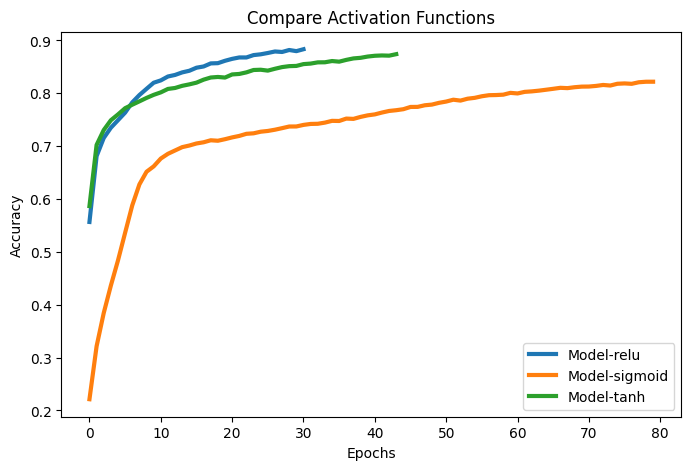

In [144]:
plot_accuracy_measures(accuracy_measures, "Compare Activation Functions")

The activation function relu have higher accuracy and completed faster.

In [145]:
model_config['hidden_activation'] = 'relu'

### Initialize Weights
The initial values of weights play a huge role in the speed of learning and finaly accuracy. Multiple initialization techniques exist.

Random normal works best for most cases but we will run an experiment if that is still the case on our dataset.

Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 32)                1664      
                                                                 
 dense_134 (Dense)           (None, 16)                528       
                                                                 
 dense_135 (Dense)           (None, 16)                272       
                                                                 
 dense_136 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 7ms/step - loss: 1.4373 - accuracy: 0.3748 - val_loss: 1.2877 - val_accuracy: 0.4890
Epoch

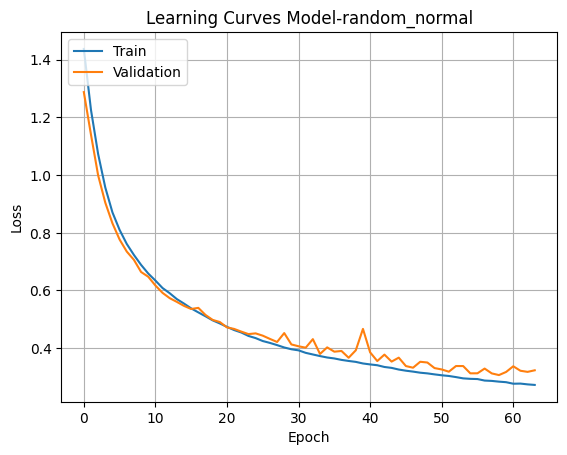

Model: "Model-random_uniform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_137 (Dense)           (None, 32)                1664      
                                                                 
 dense_138 (Dense)           (None, 16)                528       
                                                                 
 dense_139 (Dense)           (None, 16)                272       
                                                                 
 dense_140 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 7ms/step - loss: 1.4155 - accuracy: 0.3817 - val_loss: 1.2442 - val_accuracy: 0.4743
Epoc

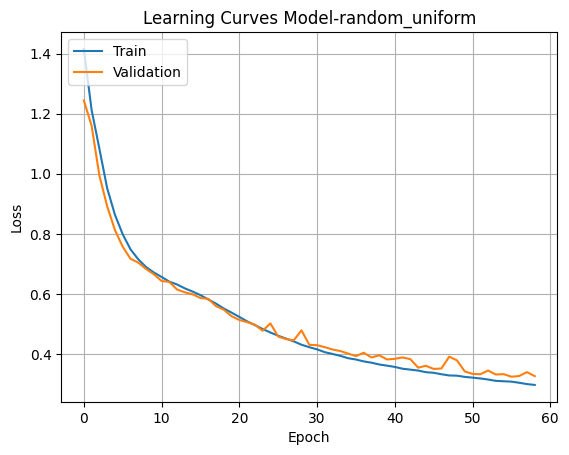

In [146]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'

initializer_list = ['random_normal', "random_uniform"]

for initializer in initializer_list:

  model_config['weights_initializer'] = initializer

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + initializer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [147]:
accuracy_measures_weight_init = accuracy_measures.copy()

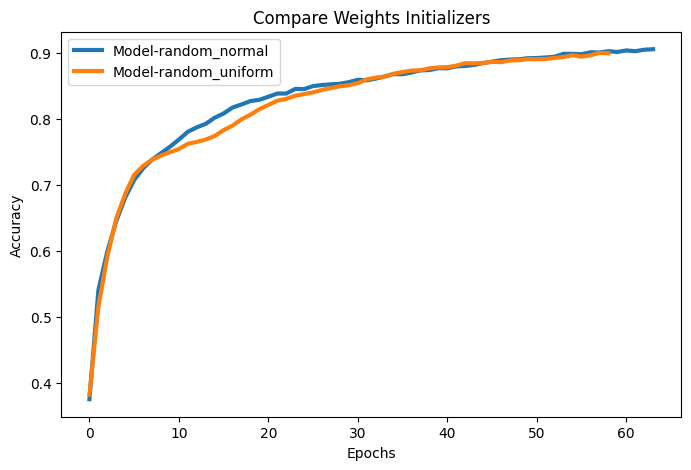

In [148]:
plot_accuracy_measures(accuracy_measures, "Compare Weights Initializers")

Both weight initializer offers higher accuracy but I will choose random_uniform since it completed faster and have slight better advantage on the learnign curve.

In [ ]:
model_config['weights_initializer'] = 'random_uniform'

## Tuning Back Propagation

### Batch Normalization

Batch normalization is an important technique to vanishing and exploiting gradients during gradient descent. Batch normalization help achieve higher accuracies with lower epochs, hence is also an optimization technique.

*This is no longer necessary because Scaler was already applied during data preparation. However, in order to show the difference, I am also running this experiment.*

Model: "Normalization-batch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 32)                1664      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense_142 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_143 (Dense)           (None, 16)                272       
                                                                 
 batch_normalization_2 (Bat  (None, 16)        

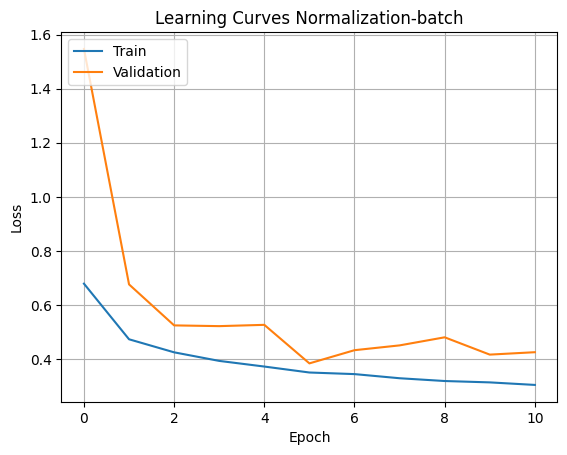

Model: "Normalization-none"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_145 (Dense)           (None, 32)                1664      
                                                                 
 dense_146 (Dense)           (None, 16)                528       
                                                                 
 dense_147 (Dense)           (None, 16)                272       
                                                                 
 dense_148 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 2s 5ms/step - loss: 1.4607 - accuracy: 0.3472 - val_loss: 1.2740 - val_accuracy: 0.4583
Epoch 

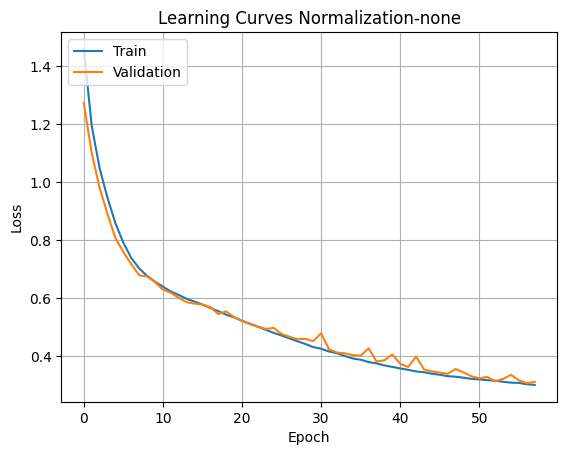

In [149]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'

normalization_list = ['batch','none']
for normalization in normalization_list:

  custom_layers = []
  if normalization == 'none':
    custom_layers = [
      layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];
  else:
    custom_layers = [
      layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.BatchNormalization(),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.BatchNormalization(),
      layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.BatchNormalization(),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];


  model_name = 'Normalization-' + normalization
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [150]:
accuracy_measures_normalization = accuracy_measures.copy()

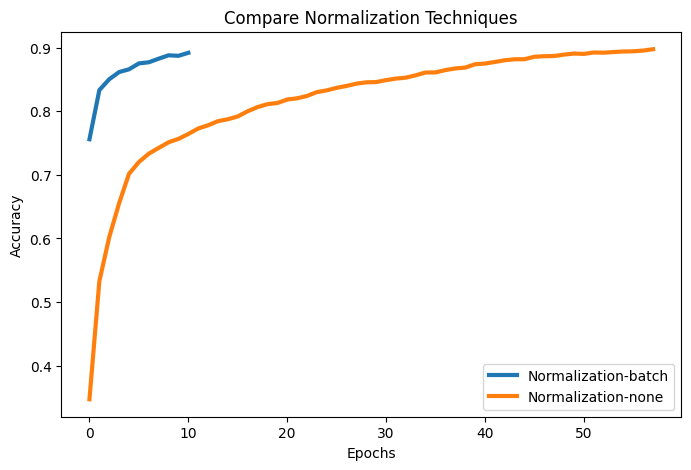

In [151]:
plot_accuracy_measures(accuracy_measures, "Compare Normalization Techniques")

Not applying a normalization layer results to a better choice.

### Optimizers
Optimizer are key tools, that help gradient descent, achieve faster results. Optimizers are algorithms, that helps speed up the training process.

Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 32)                1664      
                                                                 
 dense_150 (Dense)           (None, 16)                528       
                                                                 
 dense_151 (Dense)           (None, 16)                272       
                                                                 
 dense_152 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 6s 9ms/step - loss: 1.4695 - accuracy: 0.3411 - val_loss: 1.3339 - val_accuracy: 0.4267
Epoch 2/90


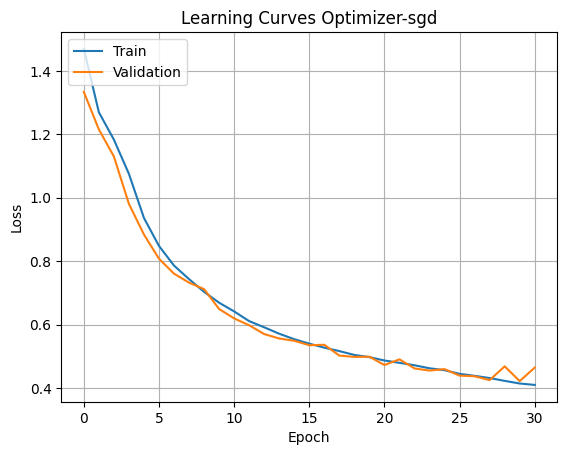

Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 32)                1664      
                                                                 
 dense_154 (Dense)           (None, 16)                528       
                                                                 
 dense_155 (Dense)           (None, 16)                272       
                                                                 
 dense_156 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 2s 5ms/step - loss: 1.4708 - accuracy: 0.3292 - val_loss: 1.2799 - val_accuracy: 0.4835
Epoch 2

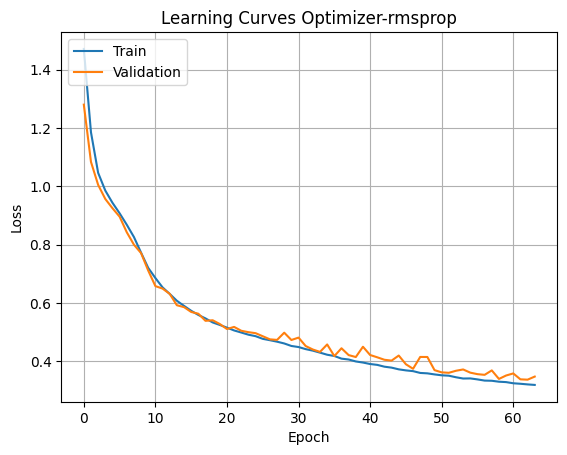

Model: "Optimizer-adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_157 (Dense)           (None, 32)                1664      
                                                                 
 dense_158 (Dense)           (None, 16)                528       
                                                                 
 dense_159 (Dense)           (None, 16)                272       
                                                                 
 dense_160 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 7ms/step - loss: 1.4968 - accuracy: 0.3323 - val_loss: 1.3223 - val_accuracy: 0.4351
Epoch 2/90

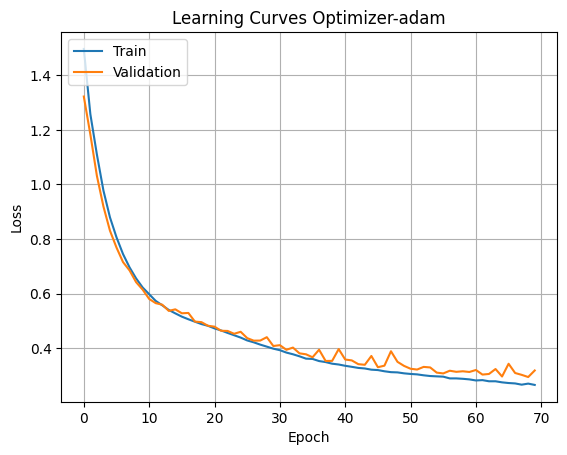

Model: "Optimizer-adagrad"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_161 (Dense)           (None, 32)                1664      
                                                                 
 dense_162 (Dense)           (None, 16)                528       
                                                                 
 dense_163 (Dense)           (None, 16)                272       
                                                                 
 dense_164 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 4s 7ms/step - loss: 1.6090 - accuracy: 0.2176 - val_loss: 1.6086 - val_accuracy: 0.2140
Epoch 2

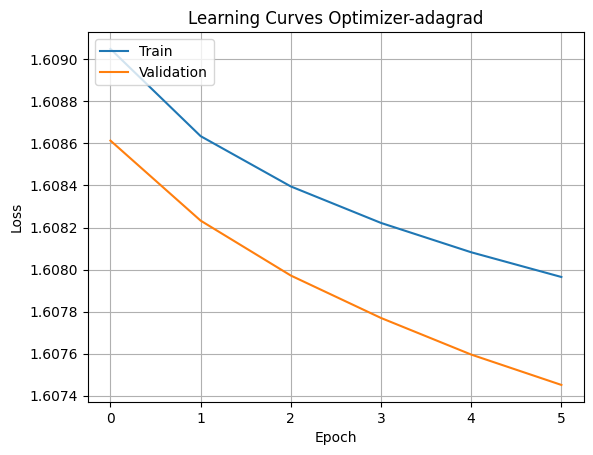

In [152]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added

optimizer_list = ['sgd','rmsprop','adam','adagrad']

for optimizer in optimizer_list:

  model_config['optimizer'] = optimizer

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Optimizer-' + optimizer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [153]:
accuracy_measures_optimizer = accuracy_measures.copy()

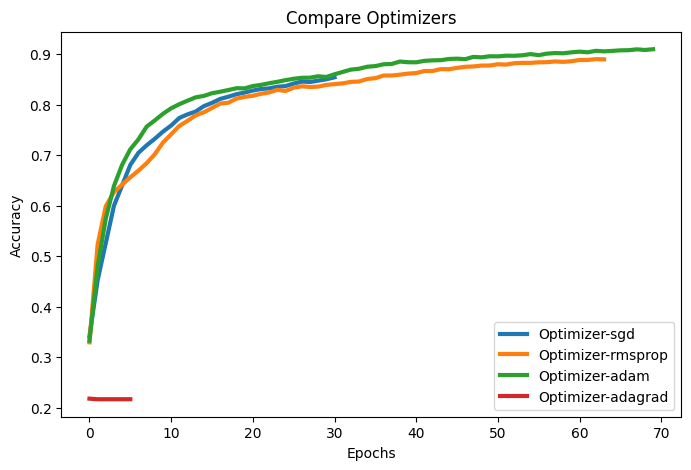

In [154]:
plot_accuracy_measures(accuracy_measures, "Compare Optimizers")

There are two possible good candidates for optimizer. The Optimizer-sgd is faster but with lower accuracy and Optimizer-adam which is offers higher accuracy but slower since it runs on more epoch. For this use case we are more leaning toward to accuracy. Hence, choosing adam as optimizer.

In [157]:
model_config['optimizer'] = 'adam'

### Learning Rates

Learning rate is the rate at  which the weights will change in response to the estimated error. It is the speed at which the model is expected to learn from the training data and adjust its weights. Learning rates work in conjunction with the optimizer.

Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_169 (Dense)           (None, 32)                1664      
                                                                 
 dense_170 (Dense)           (None, 16)                528       
                                                                 
 dense_171 (Dense)           (None, 16)                272       
                                                                 
 dense_172 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 7ms/step - loss: 1.4495 - accuracy: 0.3181 - val_loss: 1.3016 - val_accuracy: 0.4316
Epoch

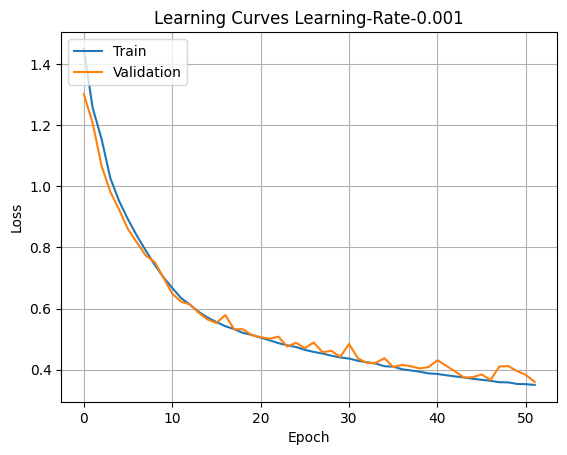

Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_173 (Dense)           (None, 32)                1664      
                                                                 
 dense_174 (Dense)           (None, 16)                528       
                                                                 
 dense_175 (Dense)           (None, 16)                272       
                                                                 
 dense_176 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 2s 5ms/step - loss: 1.1553 - accuracy: 0.5261 - val_loss: 0.9260 - val_accuracy: 0.6395
Epoch

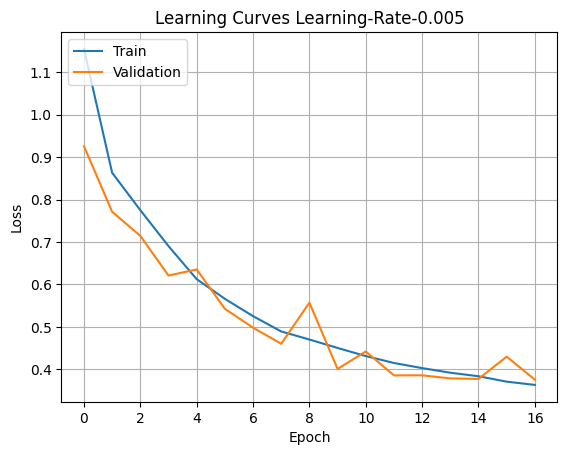

Model: "Learning-Rate-0.01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_177 (Dense)           (None, 32)                1664      
                                                                 
 dense_178 (Dense)           (None, 16)                528       
                                                                 
 dense_179 (Dense)           (None, 16)                272       
                                                                 
 dense_180 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 4s 8ms/step - loss: 1.1411 - accuracy: 0.5325 - val_loss: 0.8375 - val_accuracy: 0.7085
Epoch 

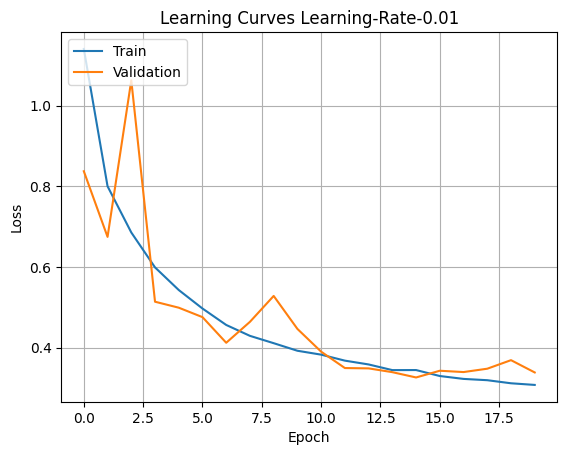

Model: "Learning-Rate-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_181 (Dense)           (None, 32)                1664      
                                                                 
 dense_182 (Dense)           (None, 16)                528       
                                                                 
 dense_183 (Dense)           (None, 16)                272       
                                                                 
 dense_184 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 2s 5ms/step - loss: 1.6227 - accuracy: 0.2081 - val_loss: 1.6092 - val_accuracy: 0.2134
Epoch 2

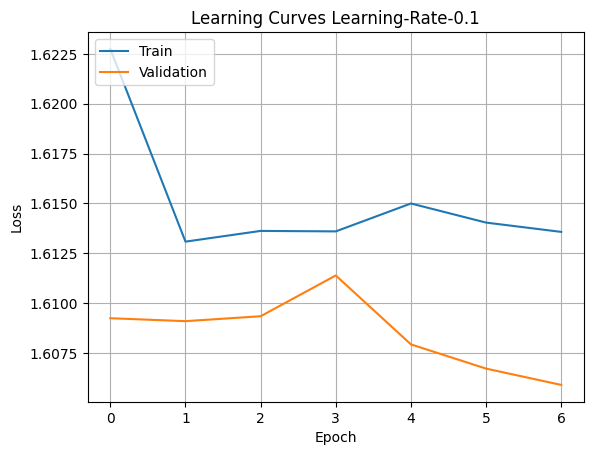

In [158]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added
model_config['optimizer'] = 'adam'

learning_rate_list = [0.001, 0.005, 0.01, 0.1]

for learning_rate in learning_rate_list:

  model_config['learning_rate'] = learning_rate

  custom_layers = [
    layers.Dense(32, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Learning-Rate-' + str(learning_rate)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [161]:
accuracy_measures_learning_rate = accuracy_measures.copy()

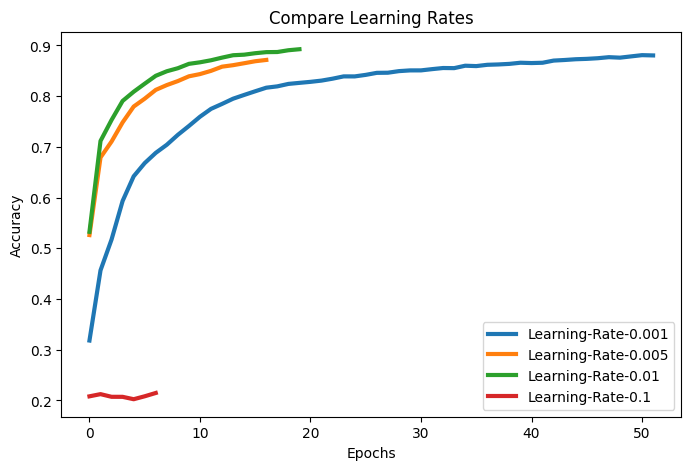

In [162]:
plot_accuracy_measures(accuracy_measures, "Compare Learning Rates")

The learning rate 0.01 and 0.005 offers a higher accuracy but it is unstable compared to 0.001. Thus, selecting the model with a learning rate of 0.001

In [163]:
model_config['learning_rate'] = 0.001

## Overfitting Management

### Regularization
Regularization is an important technique for managing overfitting in neural networks. Regularization algorithms provide an adjustments to the model parameters after they are updated. The adjustment reduces the variance in the model by providing a penalty when overfitting.

Testing: l1
Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 32)                1664      
                                                                 
 dense_186 (Dense)           (None, 16)                528       
                                                                 
 dense_187 (Dense)           (None, 16)                272       
                                                                 
 dense_188 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 6ms/step - loss: 1.6397 - accuracy: 0.2103 - val_loss: 1.6169 - val_accuracy: 0.214

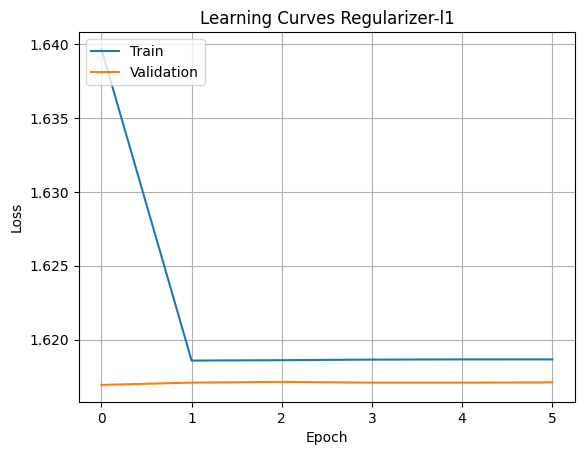

Testing: l2
Model: "Regularizer-l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 32)                1664      
                                                                 
 dense_190 (Dense)           (None, 16)                528       
                                                                 
 dense_191 (Dense)           (None, 16)                272       
                                                                 
 dense_192 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 4s 7ms/step - loss: 1.6083 - accuracy: 0.2143 - val_loss: 1.6055 - val_accuracy: 0.214

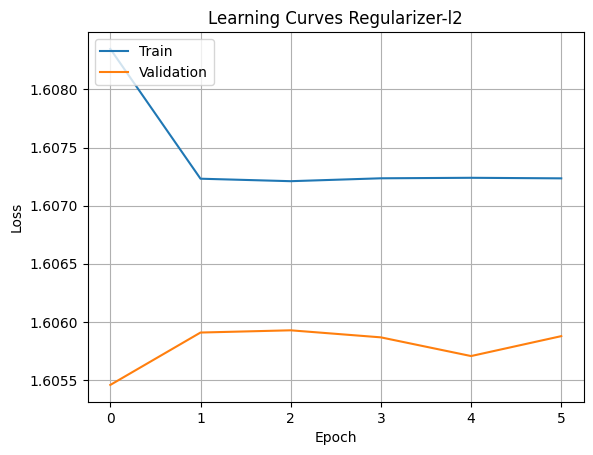

Testing: l1_l2
Model: "Regularizer-l1_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_193 (Dense)           (None, 32)                1664      
                                                                 
 dense_194 (Dense)           (None, 16)                528       
                                                                 
 dense_195 (Dense)           (None, 16)                272       
                                                                 
 dense_196 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 5ms/step - loss: 1.6407 - accuracy: 0.2138 - val_loss: 1.6178 - val_accuracy:

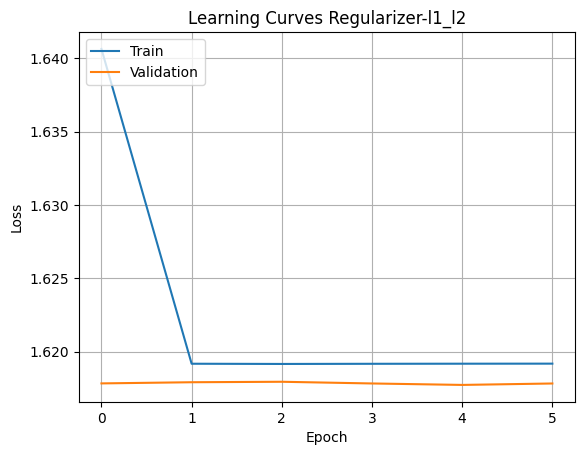

Testing: None
Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 32)                1664      
                                                                 
 dense_198 (Dense)           (None, 16)                528       
                                                                 
 dense_199 (Dense)           (None, 16)                272       
                                                                 
 dense_200 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 7ms/step - loss: 1.4861 - accuracy: 0.3126 - val_loss: 1.3429 - val_accuracy: 0

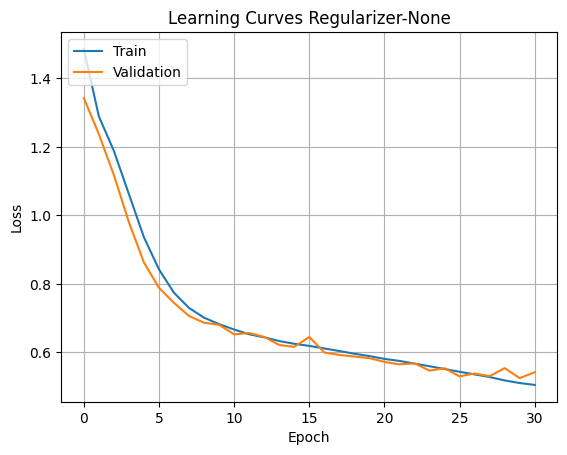

In [164]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added
model_config['optimizer'] = 'adam'
model_config['learning_rate'] = 0.001

regularizer_list = ['l1','l2','l1_l2', 'None']

for regularizer in regularizer_list:
  if regularizer == 'None':
    regularizer = None

  model_config['regularizer'] = regularizer
  print('Testing: {}'.format(regularizer))

  custom_layers = [
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Regularizer-' + str(regularizer)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [165]:
accuracy_measures_regularizer = accuracy_measures.copy()

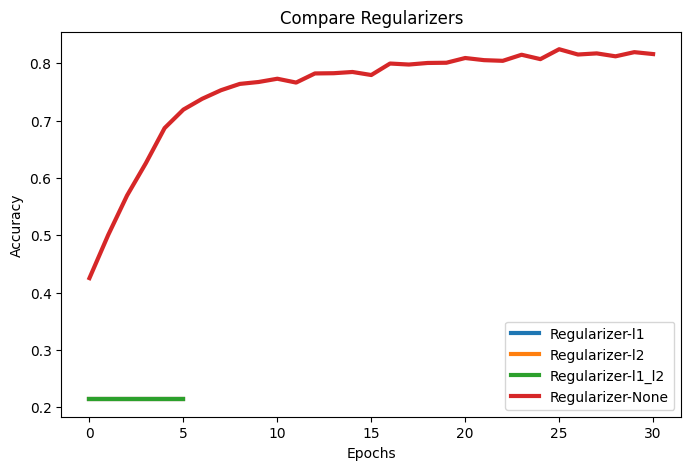

In [166]:
plot_accuracy_measures(accuracy_measures, "Compare Regularizers")

Applyin

In [167]:
model_config['regularizer'] = None

### Dropout
Dropout works during forward propagation. By default, during forward propagation, the  output of each node in the layer is sent every node in the next layer. When using dropout, the outputs of some of the nodes in the layer are dropped randomly.

Model: "Dropout-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 32)                1664      
                                                                 
 dense_202 (Dense)           (None, 16)                528       
                                                                 
 dense_203 (Dense)           (None, 16)                272       
                                                                 
 dense_204 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2549 (9.96 KB)
Trainable params: 2549 (9.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/90
318/318 [==============================] - 3s 6ms/step - loss: 1.4320 - accuracy: 0.3843 - val_loss: 1.2392 - val_accuracy: 0.4801
Epoch 2/90
3

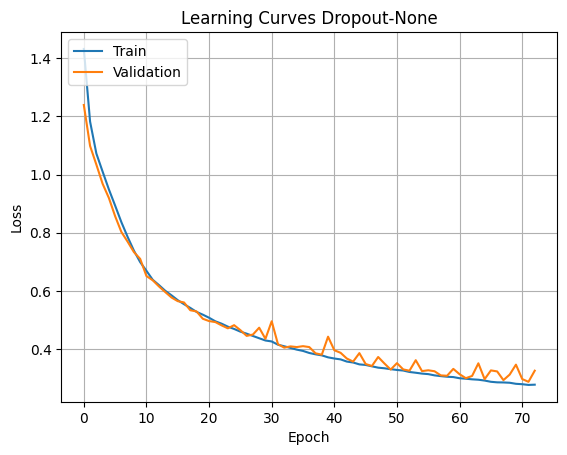

Model: "Dropout0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_205 (Dense)           (None, 32)                1664      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_206 (Dense)           (None, 16)                528       
                                                                 
 dropout_34 (Dropout)        (None, 16)                0         
                                                                 
 dense_207 (Dense)           (None, 16)                272       
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_208 (Dense)           (None, 5)                

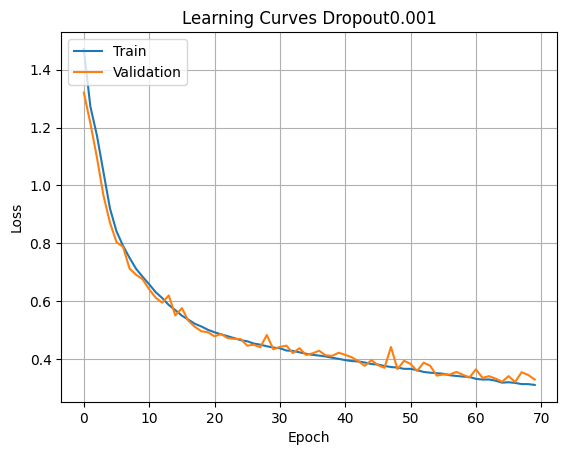

Model: "Dropout0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_209 (Dense)           (None, 32)                1664      
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_210 (Dense)           (None, 16)                528       
                                                                 
 dropout_37 (Dropout)        (None, 16)                0         
                                                                 
 dense_211 (Dense)           (None, 16)                272       
                                                                 
 dropout_38 (Dropout)        (None, 16)                0         
                                                                 
 dense_212 (Dense)           (None, 5)                 8

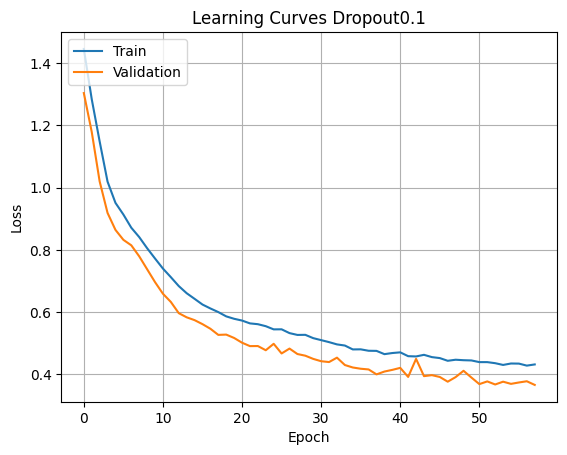

Model: "Dropout0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_213 (Dense)           (None, 32)                1664      
                                                                 
 dropout_39 (Dropout)        (None, 32)                0         
                                                                 
 dense_214 (Dense)           (None, 16)                528       
                                                                 
 dropout_40 (Dropout)        (None, 16)                0         
                                                                 
 dense_215 (Dense)           (None, 16)                272       
                                                                 
 dropout_41 (Dropout)        (None, 16)                0         
                                                                 
 dense_216 (Dense)           (None, 5)                 8

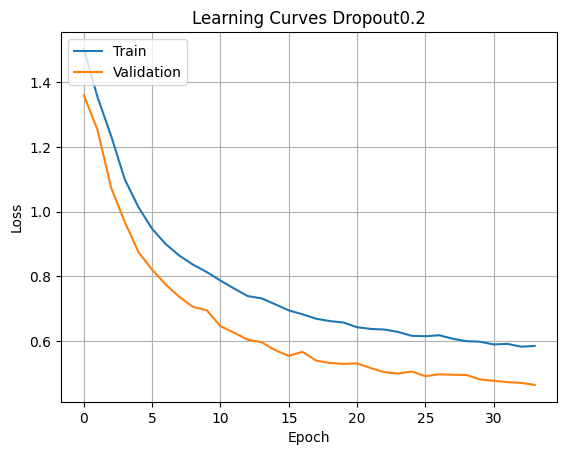

Model: "Dropout0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_217 (Dense)           (None, 32)                1664      
                                                                 
 dropout_42 (Dropout)        (None, 32)                0         
                                                                 
 dense_218 (Dense)           (None, 16)                528       
                                                                 
 dropout_43 (Dropout)        (None, 16)                0         
                                                                 
 dense_219 (Dense)           (None, 16)                272       
                                                                 
 dropout_44 (Dropout)        (None, 16)                0         
                                                                 
 dense_220 (Dense)           (None, 5)                 8

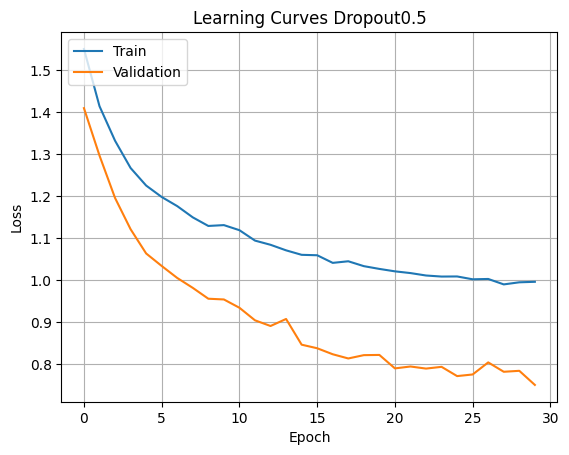

In [168]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 64
model_config['epochs'] = 90
# Number of layers: 3
# Number of nodes per each layer: 32-16-16
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_uniform'
# Batch Normalization: not added
model_config['optimizer'] = 'adam'
model_config['learning_rate'] = 0.001
model_config['regularizer'] = None
model_config['dropout_rate'] = None

dropout_list = [0.0, 0.001, 0.1, 0.2, 0.5]

for dropout in dropout_list:

  model_config['dropout_rate'] = dropout

  custom_layers = []

  if model_config['dropout_rate'] > 0.0:
    model_name = 'Dropout' + str(dropout)
    custom_layers = [
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ]
  else:
    model_name = 'Dropout-None'
    custom_layers = [
      layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ]

  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [169]:
accuracy_measures_dropout = accuracy_measures.copy()

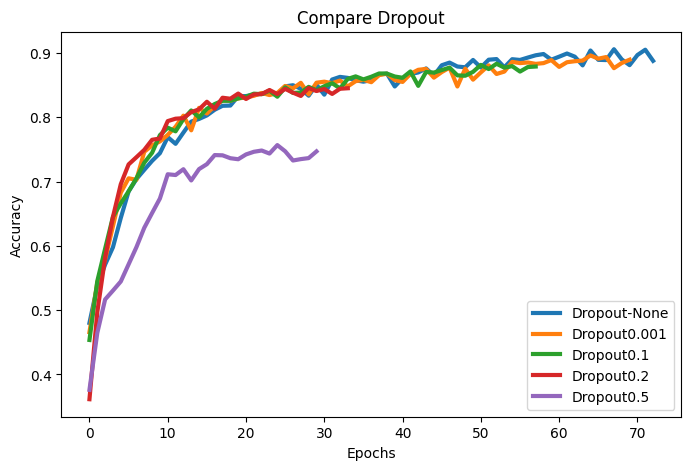

In [170]:
plot_accuracy_measures(accuracy_measures, "Compare Dropout")

The result of dropout experiment shows a close result between Dropout-None and Dropout0.001. I will choose the model Dropout0.001 because of small reduction in overfitting but slightly higher accuracy.

In [171]:
model_config['dropout_rate'] = 0.001

# Model - Evaluation

In [180]:
def get_best_param_model_config(model_name):
  """
  (str) -> dict

  This method returns the best hyper parameters from experiments.

  Parameters
  ----------
  model_name - The name of the model

  Returns
  ----------
  dict - The dictionary containing the best hyper parameters from experiments.
  """
  # Default model config
  model_config = get_base_model_config()

  model_config['model_name'] = model_name

  # Include F1-Score in the metrics so we can use that score during evaluation
  model_config['metrics'] = ['accuracy', F1Score(average='macro')], # set the average so the F1-Score will not return an array per each individual classes.

  # These are the final hyperparameters that I will use in training the Models:
  # Hyperparameters:
  model_config['batch_size'] = 64
  model_config['epochs'] = 90
  # Number of layers: 3
  # Number of nodes per each layer: 32-16-16
  model_config['hidden_activation'] = 'relu'
  model_config['weights_initializer'] = 'random_uniform'
  # Batch Normalization: not added
  model_config['optimizer'] = 'adam'
  model_config['learning_rate'] = 0.001
  model_config['regularizer'] = None
  model_config['dropout_rate'] = 0.001

  custom_layers = [
    layers.Dense(32, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(16, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  # we would like to save the model starting here for evaluation.
  model_config['is_save_model'] = True

  return model_config

In [181]:
from keras.models import load_model

def evaluate_model(model_config, X, y):
  """
  (dict, tf.data.Dataset)

  This is a reusable function that load a previously trained model and run an evaluation.

  Parameters
  ----------
  model_config - The dictionary to use in model evaluation.
  test_ds - The test dataset to use in the evaluation.

  Returns
  ----------
  Dataframe - The Panda Dataframe containing the scores from the experiment. The scores includes the Accuracy and Loss.
  """
  model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
  model = load_model(model_file)

  test_loss, test_accuracy, test_f1_score = model.evaluate(X, y, verbose=model_config['verbose'])
  print(f"Test accuracy: {test_accuracy}, Test F1-Score: {test_f1_score}")

In [174]:
# reset accuracy measures
accuracy_measures = {}

In [182]:
model_name = 'Multiclass_Clarissification_of_Malicious_URL'
best_param_model_config = get_best_param_model_config(model_name)

In [183]:
best_model_history = create_and_run_model(best_param_model_config, X_train, y_train_dummy)

Model: "Multiclass_Clarissification_of_Malicious_URL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_225 (Dense)           (None, 32)                1664      
                                                                 
 dropout_48 (Dropout)        (None, 32)                0         
                                                                 
 dense_226 (Dense)           (None, 16)                528       
                                                                 
 dropout_49 (Dropout)        (None, 16)                0         
                                                                 
 dense_227 (Dense)           (None, 16)                272       
                                                                 
 dropout_50 (Dropout)        (None, 16)                0         
                                                                 
 dense_228 (Dense)    

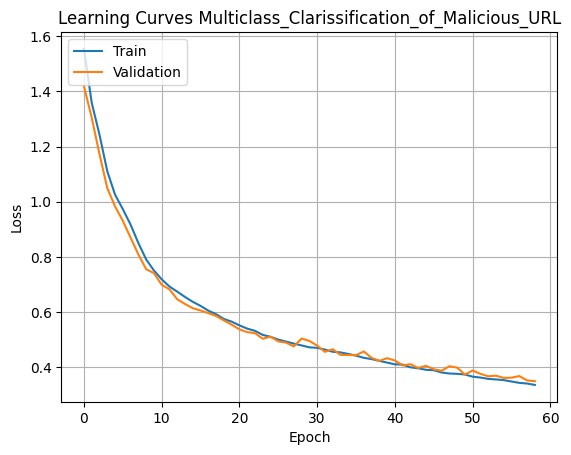

In [184]:
plot_learning_curves(best_model_history, model_name)

In [185]:
evaluate_model(best_param_model_config, X_test, y_test_dummy)

341/341 [==============================] - 1s 3ms/step - loss: 0.3537 - accuracy: 0.8816 - f1_score: 0.8829
Test accuracy: 0.8815813660621643, Test F1-Score: 0.8828716278076172
